## work with this dataset
https://raw.githubusercontent.com/Chang-Siang/IndustryElec/master/Data/industryElec_processed_20160101_20190930.csv

In [1]:
import tensorflow as tf
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# load package
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

In [3]:
# load package
from plotly.offline import iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
# 進度條工具
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector, Activation
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


### Sub：Metrics
---

In [5]:
# Metrics
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [6]:
def showPlot(true, prediction, title, sub_title, size='M', save=False):
    # 列印績效圖表，可以選擇是否儲存
    size == 'L' and plt.figure(figsize=(28, 10))
    plt.plot(true, color='red', label='Real')
    plt.plot(prediction, color='blue', label='Prediction')
    plt.title('Industry Elec Prediction %s %s t:%d' % (title, sub_title, time))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    save and plt.savefig('Image/%s-%s-%d.png' % (title, sub_title, time))
    plt.show()

In [7]:
def showModelLoss(history, startFrom=10):
    plt.plot(history.history['loss'][startFrom:], label = 'loss')
    plt.plot(history.history['val_loss'][startFrom:], color = 'red', label = 'val_loss')
    plt.legend()
    plt.show()

### Sub：Data Processing
---

In [8]:
def augFeatures(data, features_select): # 資料特徵擷取
    data = pd.DataFrame(data[features_select])
    return data

In [9]:
def fitNormalize(data, trainTo): # 計算正規化倍率
    # 獲得訓練資料的尾端
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    trainData = pd.DataFrame(data[:num_train_to])
    # 僅使用資訓練資料計算正歸化倍率
    sc = MinMaxScaler(feature_range=(0, 1))
    sc.fit_transform(trainData)
    data_scaled = doNormalize(sc, data)
    return sc, data_scaled

def doNormalize(sc, data): # 正規化
    data_scaled = pd.DataFrame(sc.transform(data))
    return data_scaled

def deNormalize(sc, value): # 還原尺度
    value_unscaled = value * \
        (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    value_unscaled = value_unscaled.reshape(value_unscaled.shape[0])
    return value_unscaled

In [10]:
# 根據給定的時間範圍自動產生訓練集
def split_train(data, trainFrom, trainTo, pastDay=7, futureDay=7):
    num_train_from = df[df['Date'] == trainFrom].index.item()
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    RawTrain = data[num_train_from:num_train_to]
    # print('RawTrain', RawTrain.shape)
    return RawTrain
# 根據給定的時間範圍自動產生測試集
def split_test(data, testFrom, testTo, pastDay=7, futureDay=7):
    num_test_from = df[df['Date'] == testFrom].index.item()
    num_test_to = df[df['Date'] == testTo].index.item() + 1
    RawTest = data[num_test_from-pastDay:num_test_to]
    # print('RawTest', RawTest.shape)
    return RawTest
# 拆分訓練與驗證，需要手動切割時才使用
def split_val(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [11]:
def buildTrain(train, pastDay, futureDay): # 滾動訓練資料
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])  # kW
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    # print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [12]:
def buildTest(test, pastDay, futureDay): # 滾動測試資料
    input_set, truth_set = test, test[pastDay:]
    X_test, Y_truth = [], []
    for i in range(0, int((test.shape[0]-pastDay)/futureDay)):
        X_test.append(input_set[futureDay*i:futureDay*i+pastDay])
        Y_truth.append(truth_set[i*futureDay:(i+1)*futureDay, 0])  # kW
    testInput, testTruth = np.array(X_test), np.array(Y_truth)
    testInput = testInput.reshape(testInput.shape[0], testInput.shape[1], testInput.shape[2])
    testTruth = testTruth.reshape(testTruth.shape[0] * testTruth.shape[1])
    # print('testInput.shape, testTruth.shape', testInput.shape, testTruth.shape)
    return testInput, testTruth

### Sub：Peak Load
---

In [13]:
# 定義 PeakLoad 相關參數
pl_features = [
    'PeakLoad(MW)',
    'isHoliday_shift7',
    'dayOfYear',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7',
]

weekCutList = ['MON/SUN', 'TUE/MON', 'WED/TUE',
               'THU/WED', 'FRI/THU', 'SAT/FRI', 'SUN/SAT']
# +7(shift)
weekCut_from_to = [{'from': '2019-01-07',
                    'to': '2019-10-06'},
                   {'from': '2019-01-01',
                    'to': '2019-10-07'},
                   {'from': '2019-01-02',
                    'to': '2019-10-01'},
                   {'from': '2019-01-03',
                    'to': '2019-10-02'},
                   {'from': '2019-01-04',
                    'to': '2019-10-03'},
                   {'from': '2019-01-05',
                    'to': '2019-10-04'},
                   {'from': '2019-01-06',
                    'to': '2019-10-05'}]

In [14]:
def loadPeakLoadModel():
    p = IntProgress()
    display(p)
    model_list = []
    for i in range(10):
        p.value += 10
        p.description = 'load %d/%d'%((i+1), 10)
        model = load_model('Model/PeakLoad/PeakLoad_%d_%d.h5' % (1, i))
        model_list.append(model)
    return model_list

In [15]:
def replacePeakLoad(weekCut_Text, RawData): # 替換尖峰負載
    weekCut = weekCutList.index(weekCut_Text)
    pl_RawData = augFeatures(df, pl_features)
    pl_sc, pl_RawData_n = fitNormalize(pl_RawData, trainTo)
    df_shift = forecastPeakLoad(weekCut, pl_RawData_n, pl_sc)
    df_index = df[df['Date'] == '2019-09-30'].index.item() + 1 
    RawData['PeakLoad(MW)_shift7'] = df_shift[:df_index]
    return RawData

In [16]:
def forecastPeakLoad(weekCut, RawData, sc): # 預測尖峰負載 & shift
    print("- PeakLoad %s" % (weekCutList[weekCut]))
    # 將'PeakLoad(MW)_shift7'還原為初始狀態(shift前、真實值)
    df_shift = df.copy()
    df_shift['PeakLoad(MW)_shift7'] = df_shift['PeakLoad(MW)']
    weekCut_range = (df_shift['Date'] >= weekCut_from_to[weekCut].get('from')) & (
        df_shift['Date'] <= weekCut_from_to[weekCut].get('to'))
    # 執行預測
    weekCutRaw = split_test(RawData,
                            weekCut_from_to[weekCut].get('from'),
                            weekCut_from_to[weekCut].get('to'),
                            pastDay, futureDay)
    weekCutInput, weekCutTruth = buildTest(
        weekCutRaw.values, pastDay, futureDay)
    weekCutPredict = []
    for j in range(10):
        temp = model_evaluate(pl_model[j], sc, weekCutTruth, weekCutInput)
        weekCutPredict.append(temp.reshape(temp.shape[0]))
    weekCutPredict = np.array(weekCutPredict).mean(axis=0)
    df_shift.at[df_shift[weekCut_range].index.tolist(
    ), 'PeakLoad(MW)_shift7'] = weekCutPredict
    # 檢視替換後的績效
    df_weekCut = df_shift[weekCut_range]
    calcError(df_weekCut['PeakLoad(MW)'], df_weekCut['PeakLoad(MW)_shift7'])
    # shift7 then return
    df_shift['PeakLoad(MW)_shift7'] = df_shift['PeakLoad(MW)_shift7'].shift(-7, axis=0)
    return df_shift['PeakLoad(MW)_shift7']

### Sub：Model
---

In [17]:
def buildModel(shape, train_x, train_y):
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    epochs, batch_size = 1000, 16
    model = Sequential()
    model.add(CuDNNLSTM(units=200, input_shape=(shape[1], shape[2])))
#     model.add(Activation('relu')) # tanh
    model.add(RepeatVector(futureDay)) # futureDay = 7
    
    model.add(CuDNNLSTM(200, return_sequences=True))
#     model.add(Activation('relu')) # tanh

    model.add(TimeDistributed(Dense(200, activation='relu')))
    model.add(TimeDistributed(Dense(1)))

    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=30, mode='min', verbose=0)
    earlyStop = EarlyStopping(
        monitor="val_loss", patience=150, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y,
                            epochs=epochs, batch_size=batch_size,
                            verbose=0,
                            validation_split=0.1,
                            callbacks=[reduce_lr, earlyStop])
    return model, modelResult

In [18]:
def model_forecast(model, input_data):
    forecast_temp = model.predict(input_data)
    forecast = forecast_temp.reshape(
        forecast_temp.shape[0] * forecast_temp.shape[1])
    return forecast

In [19]:
def model_evaluate(model, sc, truth, input_set):
    truth = pd.DataFrame(truth)
    truth = deNormalize(sc, truth.values)
    predict = model_forecast(model, input_set)
    predict = deNormalize(sc, predict)
    return predict

### Main
---

In [20]:
%%time
# load peak load model
pl_model = loadPeakLoadModel()

IntProgress(value=0)


Wall time: 30.5 s


In [21]:
# 步數選擇
pastDay = 7
futureDay = 7

weekCutList = ['MON/SUN', 'TUE/MON', 'WED/TUE',
               'THU/WED', 'FRI/THU', 'SAT/FRI', 'SUN/SAT']

train_from_to = [{'from': '2017-01-02',
                  'to': '2018-12-30'},
                 {'from': '2017-01-03',
                  'to': '2018-12-31'},
                 {'from': '2017-01-04',
                  'to': '2019-01-01'},
                 {'from': '2017-01-05',
                  'to': '2018-12-26'},
                 {'from': '2017-01-06',
                  'to': '2018-12-27'},
                 {'from': '2017-01-07',
                  'to': '2018-12-28'},
                 {'from': '2017-01-01',
                  'to': '2018-12-29'}]

self_from_to = [{'from': '2017-01-09',
                 'to': '2018-12-30'},
                {'from': '2017-01-10',
                 'to': '2018-12-31'},
                {'from': '2017-01-11',
                 'to': '2019-01-01'},
                {'from': '2017-01-12',
                 'to': '2018-12-26'},
                {'from': '2017-01-13',
                 'to': '2018-12-27'},
                {'from': '2017-01-14',
                 'to': '2018-12-28'},
                {'from': '2017-01-08',
                 'to': '2018-12-29'}]

test_from_to = [{'from': '2019-01-07',
                 'to': '2019-09-29'},
                {'from': '2019-01-01',
                    'to': '2019-09-30'},
                {'from': '2019-01-02',
                    'to': '2019-09-24'},
                {'from': '2019-01-03',
                    'to': '2019-09-25'},
                {'from': '2019-01-04',
                    'to': '2019-09-26'},
                {'from': '2019-01-05',
                    'to': '2019-09-27'},
                {'from': '2019-01-06',
                    'to': '2019-09-28'}]

# 定義特徵
kw_features = [
    'kW',
    'PeakLoad(MW)_shift7',
    #     'PeakLoad(MW)',
    'isHoliday_shift7',
    'dayOfYear', # 'dayOfYear_update',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7',
]

In [22]:
# 資料讀入
df = pd.read_csv('Data/IndustryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1461, 13)

In [23]:
# 預測時間
weekCut = weekCutList.index('SUN/SAT')
trainFrom, trainTo = '2017-01-05', '2018-12-26'
# trainFrom, trainTo = train_from_to[weekCut].get('from'), train_from_to[weekCut].get('to')
selfFrom, selfTo = self_from_to[weekCut].get('from'), self_from_to[weekCut].get('to')
testFrom, testTo = test_from_to[weekCut].get('from'), test_from_to[weekCut].get('to')

In [24]:
# 特徵選取
RawData = augFeatures(df, kw_features)
# 使用預測的尖峰負載替換 'PeakLoad(MW)_shift7'
RawData = replacePeakLoad('WED/TUE' ,RawData)

# 正規化
sc, RawData_n = fitNormalize(RawData, trainTo)

# 資料範圍選取
RawTrain = split_train(RawData_n, trainFrom, trainTo, pastDay, futureDay)
RawSelf = split_test(RawData_n, selfFrom, selfTo, pastDay, futureDay)
RawTest = split_test(RawData_n, testFrom, testTo, pastDay, futureDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, pastDay, futureDay)
selfInput, selfTruth = buildTest(RawSelf.values, pastDay, futureDay)
testInput, testTruth = buildTest(RawTest.values, pastDay, futureDay)

# 驗證資料
# X, Y, Xv, Yv= split_val(X_train, Y_train, 0.1)

- PeakLoad WED/TUE
RMSE 797.8181069297142
MAPE 1.8957371607171962


round:  0


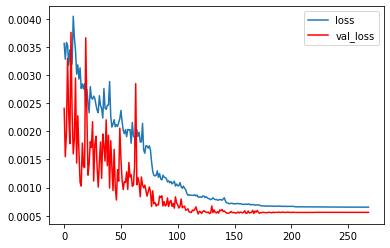

round:  1


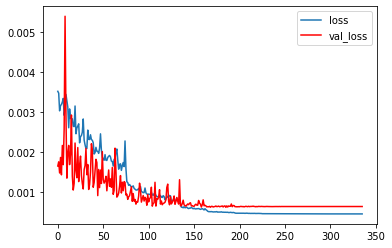

round:  2


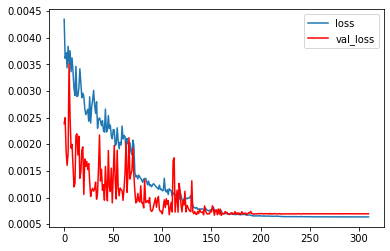

round:  3


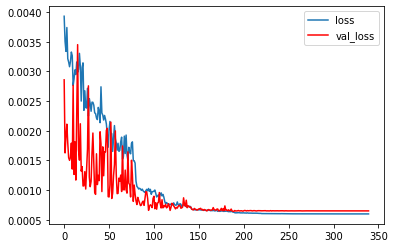

round:  4


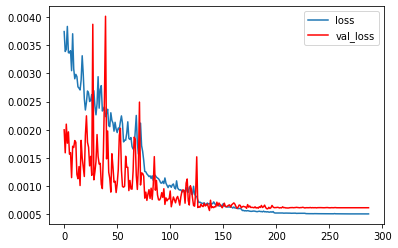

round:  5


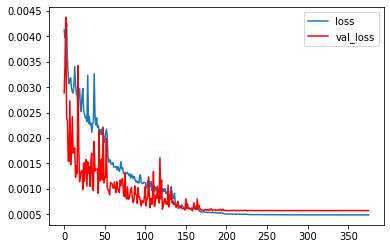

round:  6


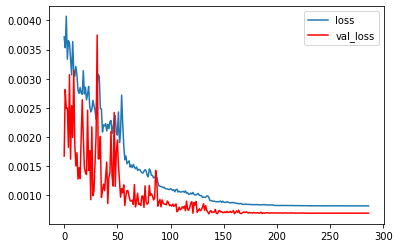

round:  7


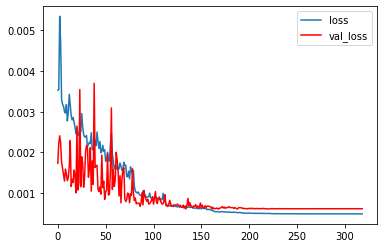

round:  8


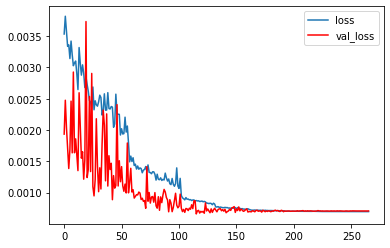

round:  9


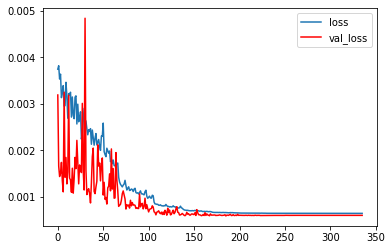

round:  10


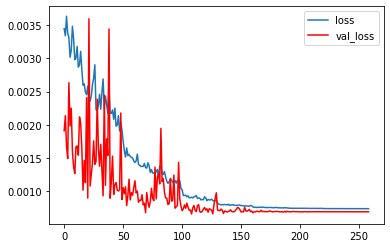

round:  11


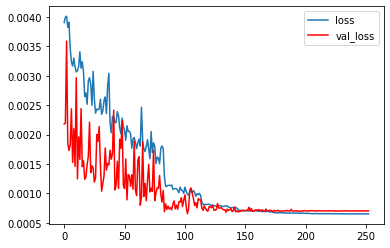

round:  12


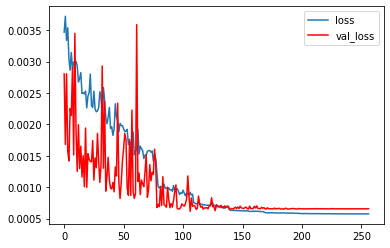

round:  13


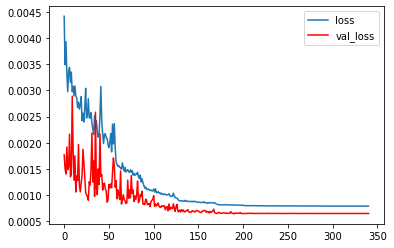

round:  14


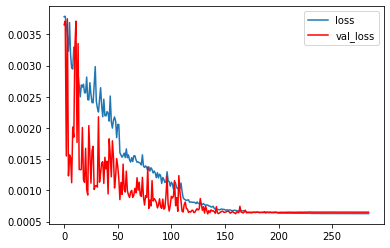

Wall time: 33min 46s


In [25]:
%%time
model_save= []

# 為求公平衡量模型，執行 n次
for i in range(15):
    print("round: ", str(i))
    model, modelResult = buildModel(X_train.shape, X_train, Y_train)
    model_save.append(model) # 儲存 model 供未來使用
    showModelLoss(modelResult, startFrom=20)

## Log Setting
##### ( 設定本次實驗的戳記代碼 )
---

In [26]:
time = 1
# save = True
save = False
model_name = '(RNN_1.78)'
# model_name = '(RNN_L1L2_5)'

## Prediction
---

In [27]:
total_self = []
total_test = []

# 為求公平衡量模型，執行 n次
for i in range(15):
#     print("round: ", str(i))
    self_predict = model_evaluate(model_save[i], sc, selfTruth, selfInput)
    test_predict = model_evaluate(model_save[i], sc, testTruth, testInput)
    total_self.append(self_predict.reshape(self_predict.shape[0]))
    total_test.append(test_predict.reshape(test_predict.shape[0]))
    
# 平均處理 n個模型的預測結果
mean_self = np.array(total_self).mean(axis=0)
mean_test = np.array(total_test).mean(axis=0)

RMSE 4.9003626097468205
MAPE 1.041723322821316


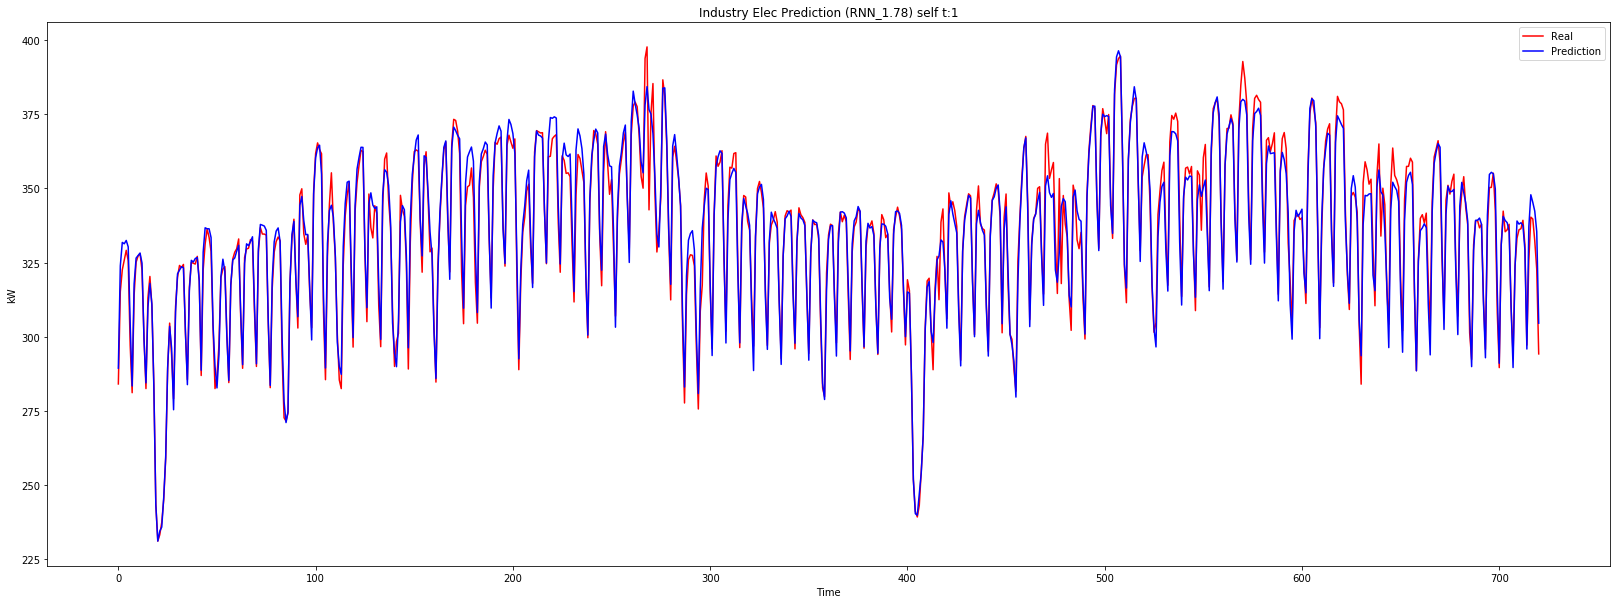

In [28]:
# 自我測試( 使用訓練資料進行預測，檢查是否過度學習 )
self_trurh = pd.DataFrame(selfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
calcError(self_trurh, mean_self)
showPlot(self_trurh, mean_self, model_name, "self", size="L", save=save)

RMSE 7.492100654957989
MAPE 1.6245483883630378


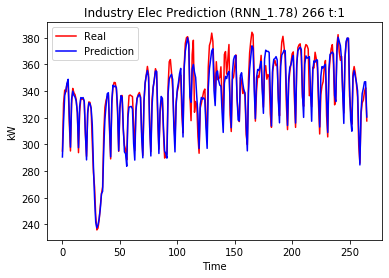

In [29]:
# 實際測試
test_trurh = pd.DataFrame(testTruth)
test_trurh = deNormalize(sc, test_trurh.values)
calcError(test_trurh, mean_test)
showPlot(test_trurh, mean_test, model_name, str(len(testTruth)), save=save)

## 特殊日替換
---

In [30]:
# 建構物件
num_test_from = df[df['Date'] == testFrom].index.item()
num_test_to = df[df['Date'] == testTo].index.item() + 1
d = {'date': pd.date_range(start = testFrom, end = testTo),
     'week': df[num_test_from:num_test_to]['week'].values,
     'isHoliday': df[num_test_from:num_test_to]['isHoliday'].values,
     'truth': test_trurh,
     'rowsMean': mean_test}
df_predict = pd.DataFrame(d)
df_predict.shape

(266, 5)

In [1]:
# 定義特殊日
_0202_0210 = (df_predict['date'] >=
              '2019-02-02') & (df_predict['date'] <= '2019-02-10')
_0228_0303 = (df_predict['date'] >=
              '2019-02-28') & (df_predict['date'] <= '2019-03-03')
_0404_0407 = (df_predict['date'] >=
              '2019-04-04') & (df_predict['date'] <= '2019-04-07')
_0501 = (df_predict['date'] >=
         '2019-05-01') & (df_predict['date'] <= '2019-05-01')
_0607_0609 = (df_predict['date'] >=
              '2019-06-07') & (df_predict['date'] <= '2019-06-09')
_0913_0915 = (df_predict['date'] >=
              '2019-09-13') & (df_predict['date'] <= '2019-09-15')

holidays = ['春節 (SAT/FRI)', '228假期 (THU/WED)', '清明假期 (THU/WED)', 
            '勞動節 (WED/TUE)', '端午假期 (FRI/THU)', '中秋假期 (FRI/THU)']

holiday_weekCut = ['SAT/FRI', 'THU/WED',
                   'THU/WED', 'WED/TUE', 'FRI/THU', 'FRI/THU']

holiday_range = [_0202_0210, _0228_0303,
                 _0404_0407, _0501, _0607_0609, _0913_0915]

holiday_from_to = [{'from': '2019-02-02',
                    'to': '2019-02-15'},
                   {'from': '2019-02-28',
                       'to': '2019-03-07'},
                   {'from': '2019-04-04',
                       'to': '2019-04-11'},
                   {'from': '2019-05-01',
                       'to': '2019-05-08'},
                   {'from': '2019-06-07',
                       'to': '2019-06-14'},
                   {'from': '2019-09-13',
                       'to': '2019-09-20'}]

holiday_len = [9, 4, 4, 1, 3, 3]

NameError: name 'df_predict' is not defined

In [32]:
# 觀察特殊日績效
for i in range(len(holidays)):
    df_temp = df_predict[holiday_range[i]]
    print("%s %d days"%(holidays[i] ,len(df_temp)))
    calcError(df_temp['truth'], df_temp['rowsMean'])

print("沒有排除特殊日（原始績效）")
calcError(df_predict['truth'], df_predict['rowsMean'])

print("排除所有特殊日")
excludeSpecialdays = ~_0202_0210 & ~_0228_0303 & ~_0404_0407 & ~_0501 & ~_0607_0609 & ~_0913_0915
df_excludeSpecialdays = df_predict[excludeSpecialdays]
calcError(df_excludeSpecialdays['truth'], df_excludeSpecialdays['rowsMean'])

print("平日(補班)")
df_excludeHolidays = df_predict[df_predict['isHoliday']==False]
calcError(df_excludeHolidays['truth'], df_excludeHolidays['rowsMean'])

print("假日(節慶)")
df_excludeNormaldays = df_predict[df_predict['isHoliday']==True]
calcError(df_excludeNormaldays['truth'], df_excludeNormaldays['rowsMean'])

print("平日")
df_exclude = df_predict[df_predict['week']<6]
calcError(df_exclude['truth'], df_exclude['rowsMean'])

print("假日")
df_exclude = df_predict[df_predict['week']>=6]
calcError(df_exclude['truth'], df_exclude['rowsMean'])

春節 (SAT/FRI) 9 days
RMSE 3.9355490683283314
MAPE 1.1960600221072601
228假期 (THU/WED) 4 days
RMSE 3.8041400937342167
MAPE 1.1976316770712636
清明假期 (THU/WED) 4 days
RMSE 3.618096745146874
MAPE 1.1136304614747803
勞動節 (WED/TUE) 1 days
RMSE 29.95110986328126
MAPE 9.241345966288469
端午假期 (FRI/THU) 3 days
RMSE 3.3419864657529597
MAPE 0.8086922631723917
中秋假期 (FRI/THU) 3 days
RMSE 5.997315611047989
MAPE 1.829540141060658
沒有排除特殊日（原始績效）
RMSE 7.492100654957989
MAPE 1.6245483883630378
排除所有特殊日
RMSE 7.508362798580799
MAPE 1.632083633770376
平日(補班)
RMSE 7.69387016443325
MAPE 1.5840521245774044
假日(節慶)
RMSE 7.058848682139566
MAPE 1.707868287416239
平日
RMSE 7.826123592033834
MAPE 1.6021813566961098
假日
RMSE 6.5833104582425195
MAPE 1.680465967530359


In [33]:
# 替換特殊日
df_update = df_predict

for i in range(len(holidays)):
    print("\n%s" % (holidays[i]))
    # 選取要重新預測的期間
    RawData = replacePeakLoad(holiday_weekCut[i] ,RawData) # 使用預測的尖峰負載替換 'PeakLoad(MW)_shift7'
    RawData_n = doNormalize(sc, RawData)
    holidayRaw = split_test(RawData_n,
                            holiday_from_to[i].get('from'),
                            holiday_from_to[i].get('to'),
                            pastDay, futureDay)
    holidayInput, holidayTruth = buildTest(
        holidayRaw.values, pastDay, futureDay)
    # 特殊日的替換也要使用 10 個 model 預測後取平均
    holidayPredict = []
    for j in range(15):
        temp = model_evaluate(model_save[j], sc, holidayTruth, holidayInput)
        holidayPredict.append(temp.reshape(temp.shape[0]))
    holidayPredict = np.array(holidayPredict).mean(axis=0)

    df_update.at[df_update[holiday_range[i]].index.tolist(),
                 'rowsMean'] = holidayPredict[:holiday_len[i]]
    # 計算替換後的績效
    df_holiday = df_update[holiday_range[i]]
    print('- Holiday')
    calcError(df_holiday['truth'], df_holiday['rowsMean'])


春節 (SAT/FRI)
- PeakLoad SAT/FRI
RMSE 861.2436623291967
MAPE 2.127752613568602
- Holiday
RMSE 15.96350878034329
MAPE 5.193602130382634

228假期 (THU/WED)
- PeakLoad THU/WED
RMSE 806.7607824256085
MAPE 1.977811408790825
- Holiday
RMSE 4.620333299642364
MAPE 1.3044993931730773

清明假期 (THU/WED)
- PeakLoad THU/WED
RMSE 806.7607824256085
MAPE 1.977811408790825
- Holiday
RMSE 6.466540173046295
MAPE 2.1187323639756914

勞動節 (WED/TUE)
- PeakLoad WED/TUE
RMSE 797.8181069297142
MAPE 1.8957371607171962
- Holiday
RMSE 24.71807763671876
MAPE 7.626705925263194

端午假期 (FRI/THU)
- PeakLoad FRI/THU
RMSE 893.9223635825992
MAPE 2.195370381069591
- Holiday
RMSE 13.203289589452602
MAPE 3.788147388045815

中秋假期 (FRI/THU)
- PeakLoad FRI/THU
RMSE 893.9223635825992
MAPE 2.195370381069591
- Holiday
RMSE 12.016366981248973
MAPE 2.962874000504975


RMSE 8.170222394936372
MAPE 1.8168396829525764


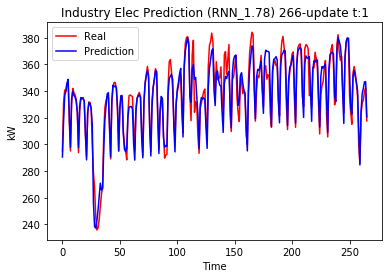

In [34]:
truth = df_update['truth']
pred = df_update['rowsMean']
calcError(truth, pred)
showPlot(truth, pred, model_name, str(len(truth))+'-update', save=save)

## Save Model
---

In [35]:
# import h5py
# Model.save('Model/IndustryElec_cLSTM(7to7)_model_%d.h5'%(time))